### **Part 1 – Problem Definition & Data Collection**

#### **1.1 Problem Definition**
   
   The goal of this project is to develop a machine learning–based QSAR model that **prioritizes small molecules according to their inhibitory activity against HIV**, using chemical structure–derived representations.

Rather than treating HIV activity prediction as a strict binary classification task, this work frames the problem as a **ranking and early recognition task**, aligned with the practical needs of early-stage virtual screening.

- **Why is this important?**  
  Experimental screening of large chemical libraries is costly and time-consuming. Computational models can rapidly filter and rank compounds, enabling experimental resources to be focused on the most promising candidates.

- **Dataset**  
  The study uses the **MoleculeNet HIV dataset**, derived from the NCI DTP AIDS Antiviral Screen.

  - **Input:** Molecular structures in SMILES format  
  - **Output:** Binary activity label  
    - 1 = active (CA/CM)  
    - 0 = inactive (CI)  
  - **Class imbalance:** ≈3.5–4% active compounds  
  - Molecular representations (fingerprints and physicochemical descriptors) are generated using **RDKit**.

- **Evaluation strategy**  
  To ensure realistic performance estimates, model evaluation emphasizes **scaffold-aware validation**, which enforces structural separation between training and evaluation sets. Stratified splitting is used only as a reference to highlight the impact of scaffold leakage.

- **Objective**  
  To build and evaluate QSAR models that can **effectively rank HIV-active compounds early**, rather than maximize accuracy at a fixed classification threshold.

  Model performance is primarily assessed using:
  - **PR-AUC** (primary metric, robust under class imbalance)  
  - **ROC-AUC** (global ranking ability)  
  - **Early enrichment metrics** (Top-N recovery of actives)  

  Threshold-dependent metrics (e.g., recall, F1-score) are reported for completeness but are not the primary optimization targets.


#### **1.2 Data Collection**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Descriptors, Crippen, Lipinski, rdMolDescriptors, rdFingerprintGenerator
from rdkit.Chem.MolStandardize import rdMolStandardize 


In [3]:
# Load MoleculeNet HIV dataset from Hugging Face
dataset = load_dataset("scikit-fingerprints/MoleculeNet_HIV")
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['SMILES', 'label'],
        num_rows: 41127
    })
})


In [4]:
## Convert train split to pandas DataFrame
df = dataset["train"].to_pandas()
df.head()

,SMILES,label
0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,0
1,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,0
2,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,0
3,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,0
4,O=S(=O)(O)CCS(=O)(=O)O,0


### **Part 2 – Exploratory Data Analysis (EDA)**

#### **2.1 Dataset Overview**

In [5]:
# Check basic dataset info
print("Shape:", df.shape)
print("Columns:", df.columns)

Shape: (41127, 2)
Columns: Index(['SMILES', 'label'], dtype='object')


In [6]:
# Check datatypes
print(df.dtypes)

SMILES    object
label      int64
dtype: object


In [7]:
# Check for missing values
print(df.isnull().sum())

SMILES    0
label     0
dtype: int64


In [8]:
# Target distribution
print(df["label"].value_counts())
print(df["label"].value_counts(normalize=True).round(3))

label
0    39684
1     1443
Name: count, dtype: int64
label
0    0.965
1    0.035
Name: proportion, dtype: float64


In [9]:
# Duplicate check
print("Unique SMILES:", df['SMILES'].nunique())
print("Total rows:", len(df))
print("Duplicate SMILES:", len(df) - df['SMILES'].nunique())

Unique SMILES: 41127
Total rows: 41127
Duplicate SMILES: 0


In [10]:
# Invalid SMILES check
from rdkit import Chem
invalid = df['SMILES'].apply(lambda x: Chem.MolFromSmiles(x) is None).sum()
print("Invalid SMILES:", invalid)

[21:02:23] WARNING: not removing hydrogen atom without neighbors
[21:02:23] WARNING: not removing hydrogen atom without neighbors


Invalid SMILES: 0


#### Chemical Standardization Strategy

Although full chemical standardization pipelines (fragment removal, uncharging, tautomer canonicalization, stereochemistry cleanup) are commonly applied when working with raw PubChem or ChEMBL datasets, they are not required for the MoleculeNet HIV dataset used in this project.

MoleculeNet provides curated, clean, and RDKit-validated structures:

- No invalid SMILES were found
- No duplicate structures exist
- No salt fragments or multi-component SMILES
- All molecules successfully parse into RDKit Mol objects

Additionally, aggressive normalization steps such as uncharging and tautomer canonicalization may remove chemically meaningful information (e.g., protonation states) that can influence bioactivity in HIV assays.

Therefore, in this project we apply only canonical SMILES generation for consistency, and intentionally avoid full chemical standardization to preserve assay-relevant structural features.


#### **2.2 SMILES String Length Distribution Analysis**

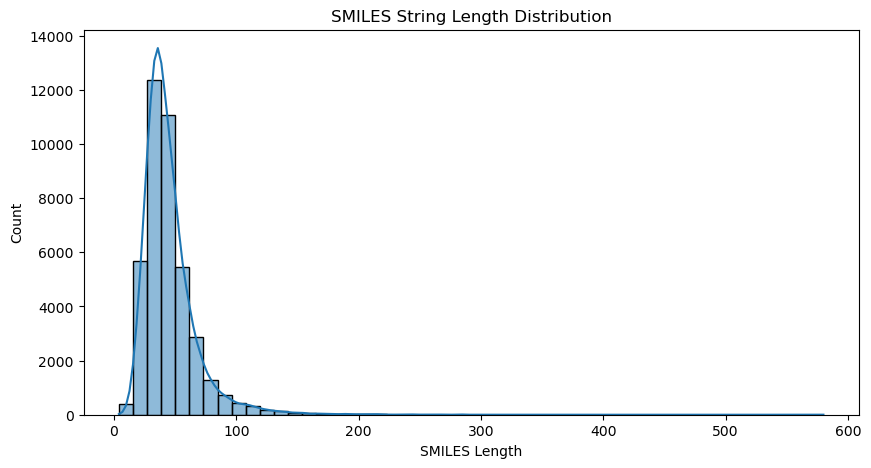

In [11]:
# Compute SMILES length
df['smiles_length'] = df['SMILES'].apply(len)

# Distribution plot
plt.figure(figsize=(10,5))
sns.histplot(df['smiles_length'], bins=50, kde=True)
plt.title("SMILES String Length Distribution")
plt.xlabel("SMILES Length")
plt.ylabel("Count")
plt.show()

#### Interpretation – SMILES Length Analysis

SMILES length is a useful proxy for **molecular complexity**, reflecting structural features such as number of atoms, branching, ring systems, and scaffold size.  
The overall distribution indicates that the MoleculeNet HIV dataset contains **chemically diverse molecules**, ranging from small fragments to large, complex inhibitors.

Importantly, **no molecules were removed based on SMILES length**, because:

- MoleculeNet is already **curated and chemically validated**  
- All SMILES strings are **RDKit-parsable**  
- Filtering solely by length may **remove meaningful HIV inhibitors**  
- Molecular complexity is part of the **chemical space that the QSAR model must learn**

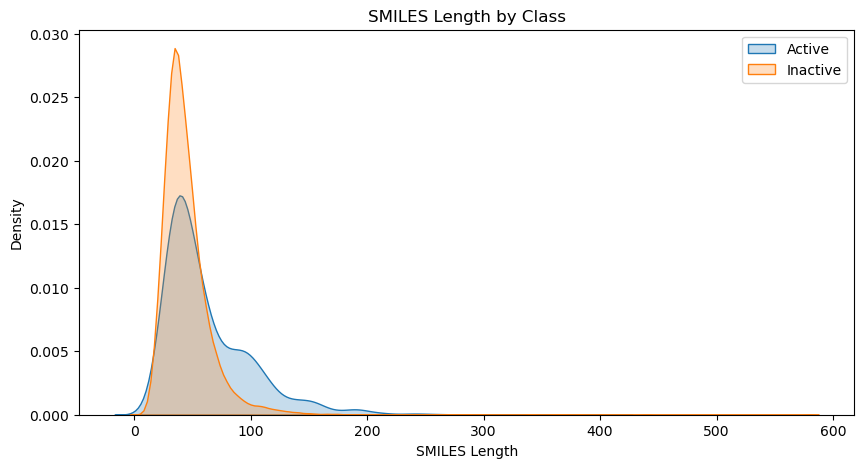

In [12]:
# Active vs Inactive Distribution

plt.figure(figsize=(10,5))
sns.kdeplot(df[df['label']==1]['smiles_length'], fill=True, label="Active")
sns.kdeplot(df[df['label']==0]['smiles_length'], fill=True, label="Inactive")
plt.title("SMILES Length by Class")
plt.xlabel("SMILES Length")
plt.legend()
plt.show()

#### Active vs. Inactive Comparison

When comparing the length distributions:

- **Inactive compounds** exhibit a *narrower range*, centered around moderate SMILES lengths  
- **Active compounds** show a *broader and slightly right-shifted distribution*, indicating  
  that HIV inhibitors tend to possess **higher structural complexity**

This observation aligns with known **SAR patterns** for HIV inhibitors,  
many of which require **larger scaffolds and more elaborate functional groups** to  
effectively interact with viral protein binding pockets.


#### **2.3 Canonical SMILES Generation (Minimal Standardization)**

In [13]:
# 1) SMILES -> RDKit Mol (create only if not already present)
if "mol" not in df.columns:
    df["mol"] = df["SMILES"].apply(lambda s: Chem.MolFromSmiles(s))

# 2) Generate canonical SMILES
df["SMILES_canonical"] = df["mol"].apply(
    lambda m: Chem.MolToSmiles(m, canonical=True) if m is not None else None
)

# 3) Quick sanity check
print(df[["SMILES", "SMILES_canonical"]].head())


[21:02:36] WARNING: not removing hydrogen atom without neighbors
[21:02:36] WARNING: not removing hydrogen atom without neighbors


                                              SMILES  \
0  CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...   
1  C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...   
2                   CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21   
3    Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1   
4                             O=S(=O)(O)CCS(=O)(=O)O   

                                    SMILES_canonical  
0  CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...  
1  C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...  
2                   CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21  
3    Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1  
4                             O=S(=O)(O)CCS(=O)(=O)O  


#### Chemical Cleaning Strategy (Filtering Not Applied)

Although many QSAR workflows include steps such as SMILES-length filtering, 
heavy-atom filtering, or salt/fragment removal, these operations were **not applied** 
in this project for the following reasons:

- The MoleculeNet HIV dataset is already **curated and chemically validated**
- No invalid SMILES, duplicate structures, or multi-component molecules were found
- Length-based or heavy-atom–based filtering may **distort the chemical space**
- Such filtering can unintentionally remove **chemically meaningful HIV inhibitors**
- Chemical complexity must remain intact for the QSAR model to learn true SAR patterns

Salt/fragment cleanup removed **0 molecules**, confirming that MoleculeNet already 
provides standardized molecular structures.

Only **canonical SMILES generation** is retained to ensure reproducibility and 
consistent representation for downstream fingerprinting.


#### **2.4 Visualization of Sample Molecules with Class Labels (RDKit)**

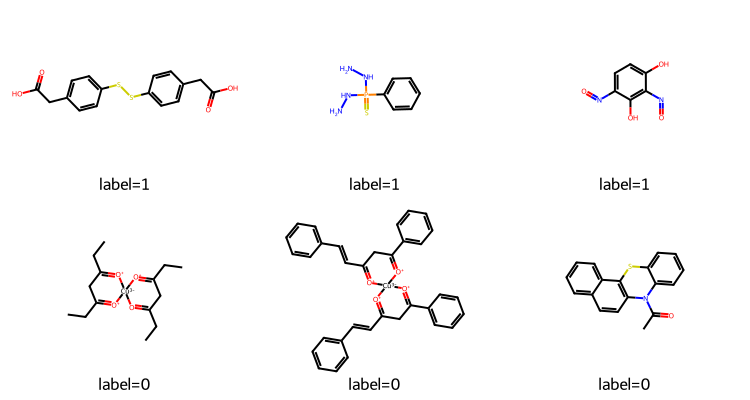

In [14]:
from rdkit.Chem.Draw import MolsToGridImage

# 1) Pick a small, balanced sample: 3 actives (1) and 3 inactives (0)
pos = df[df["label"] == 1].head(3)
neg = df[df["label"] == 0].head(3)
sample_df = pd.concat([pos, neg], ignore_index=True)

# 2) Convert SMILES -> RDKit Mol objects (skip unparseable)
mols, legends = [], []
for i, row in sample_df.iterrows():
    mol = Chem.MolFromSmiles(row["SMILES"])
    if mol is None:
        continue
    mols.append(mol)
    legends.append(f"label={row['label']}")

# 3) Draw a grid image
img = MolsToGridImage(
    mols,
    molsPerRow=3,
    subImgSize=(250, 200),
    legends=legends,
)

img

#### Interpretation – Visual Inspection of Active vs. Inactive Molecules

Visualizing representative molecules from each class provides qualitative insight into the structural differences between **active** and **inactive** compounds.

---

#### Active Compounds (label = 1)

Active molecules tend to be:

- more **compact** and **structurally focused**
- enriched with **functional groups** (e.g., OH, NH, sulfonamides)
- containing **heteroatoms** capable of forming hydrogen bonds
- featuring **aromatic systems** suitable for π–π stacking

These characteristics are consistent with known **SAR for HIV inhibitors**, which often require:

- specific **hydrogen-bond donor/acceptor** patterns  
- adequate **polarity** for binding interactions  
- **aromatic scaffolds** for hydrophobic pocket engagement  

---

#### Inactive Compounds (label = 0)

Inactive molecules often appear:

- **larger** and more **sterically congested**
- dominated by **rigid, polycyclic, hydrophobic** frameworks
- lacking key **polar functional groups** required for target binding

Such structures may suffer from:

- poor binding orientation  
- steric clash with the viral protein  
- inadequate hydrogen-bonding capability  

---

#### Conclusion

Even simple visual inspection reveals clear **structural trends** between classes.

> **Active HIV inhibitors require a balance of molecular complexity and functional-group diversity, rather than sheer size.**

These observations complement the upcoming **quantitative descriptor** and **fingerprint analyses**, helping build an early SAR intuition before modeling.


#### **2.5 Calculation of Lipinski's Drug-Likeness Descriptors**

In [15]:
# Function: compute Lipinski descriptors for a molecule
def compute_lipinski_descriptors(mol):
    if mol is None:
        return pd.Series({
            "MolWt": None,
            "MolLogP": None,
            "HBD": None,
            "HBA": None,
            "TPSA": None,
            "RotatableBonds": None
        })
    return pd.Series({
        "MolWt": Descriptors.MolWt(mol),                       # Molecular weight
        "MolLogP": Crippen.MolLogP(mol),                       # LogP
        "HBD": Lipinski.NumHDonors(mol),                       # H-bond donors
        "HBA": Lipinski.NumHAcceptors(mol),                    # H-bond acceptors
        "TPSA": rdMolDescriptors.CalcTPSA(mol),                # Polar surface area
        "RotatableBonds": rdMolDescriptors.CalcNumRotatableBonds(mol)  # Rotatable bonds
    })

# Compute descriptors
df_lipinski = df["mol"].apply(compute_lipinski_descriptors)

# Quick check
print(df_lipinski.head())


     MolWt  MolLogP  HBD  HBA    TPSA  RotatableBonds
0  319.888   2.6669  0.0  0.0   45.20             4.0
1  564.140   7.0813  0.0  0.0   45.20             6.0
2  291.375   4.9890  0.0  2.0   20.31             0.0
3  370.408   1.5148  4.0  6.0  160.78             4.0
4  190.198  -1.2380  2.0  4.0  108.74             3.0


#### **2.6 Combine Molecule Dataset and Lipinski Features**

In [16]:
# Check if both DataFrames have exactly the same index
if df.index.equals(df_lipinski.index):
    print("✅ Index match perfectly – safe to concat without reset_index.")
else:
    print("⚠️ Index do NOT match – better use reset_index(drop=True).")

# Combine original molecule data with Lipinski descriptors
df_combined = pd.concat([df, df_lipinski], axis=1)

df_combined.head()

✅ Index match perfectly – safe to concat without reset_index.


,SMILES,label,smiles_length,mol,SMILES_canonical,MolWt,MolLogP,HBD,HBA,TPSA,RotatableBonds
0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,0,52,<rdkit.Chem.rdchem.Mol object at 0x000001A1B4D...,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,319.888,2.6669,0.0,0.0,45.20,4.0
1,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,0,84,<rdkit.Chem.rdchem.Mol object at 0x000001A1B4D...,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,564.140,7.0813,0.0,0.0,45.20,6.0
2,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,0,32,<rdkit.Chem.rdchem.Mol object at 0x000001A1B4D...,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,291.375,4.9890,0.0,2.0,20.31,0.0
3,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,0,47,<rdkit.Chem.rdchem.Mol object at 0x000001A1B4D...,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,370.408,1.5148,4.0,6.0,160.78,4.0
4,O=S(=O)(O)CCS(=O)(=O)O,0,22,<rdkit.Chem.rdchem.Mol object at 0x000001A1B4D...,O=S(=O)(O)CCS(=O)(=O)O,190.198,-1.2380,2.0,4.0,108.74,3.0


#### **2.7 Class Distribution and Descriptor Analysis**

#### **2.7.1 Visualize Class Distribution**

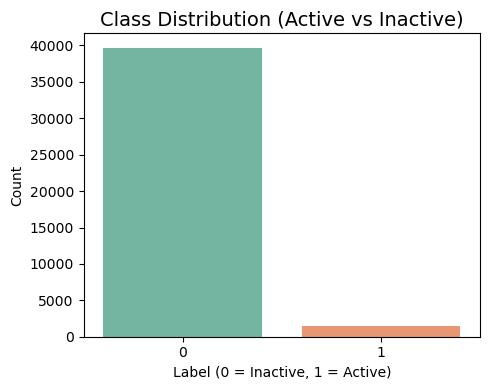

In [17]:
plt.figure(figsize=(5,4))
sns.countplot(x="label", data=df_combined, hue="label", palette="Set2", legend=False)
plt.title("Class Distribution (Active vs Inactive)", fontsize=14)
plt.xlabel("Label (0 = Inactive, 1 = Active)")
plt.ylabel("Count")

# Save plot as PNG (300 dpi) for reporting
plt.tight_layout()
plt.savefig("class_distribution.png", dpi=300)
plt.show()


#### Interpretation – Class Distribution (Active vs. Inactive)

The dataset exhibits a strong class imbalance, with the majority of compounds labeled as inactive (~40,000) and only a small fraction labeled as active (~1,400).
This imbalance is typical for biological screening datasets and indicates that:

- A naïve classifier could achieve high accuracy by predicting only the majority class.
- Metrics such as F1-score, recall, precision, and ROC-AUC are more informative than accuracy.
- Techniques like class weights, stratified splitting, and balanced evaluation metrics will be necessary during model development.

Understanding this imbalance is essential to avoid biased models and ensure reliable evaluation of predictive performance.


#### **2.7.2 Visualize Descriptor Distribution**

##### **Descriptor Histograms**

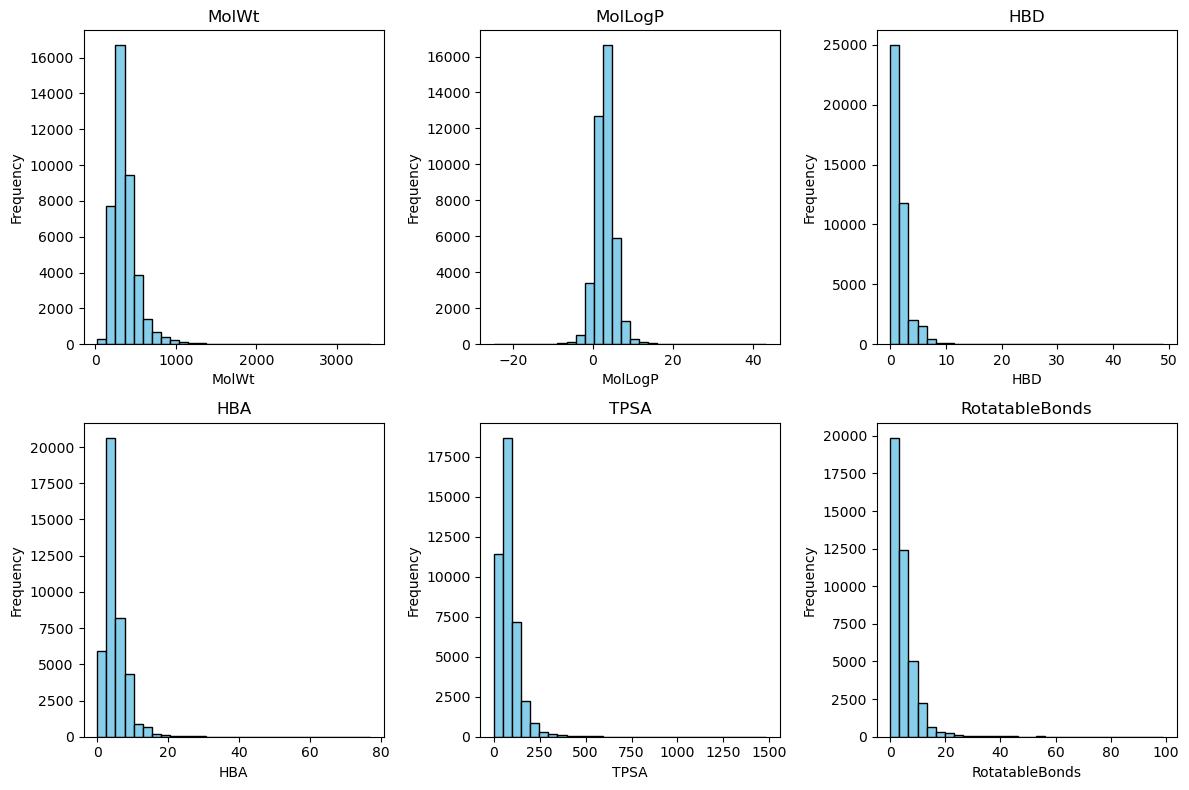

In [18]:
import os

# Descriptor columns to visualize
desc_cols = ["MolWt", "MolLogP", "HBD", "HBA", "TPSA", "RotatableBonds"]

# Create a folder to save histograms
save_dir = "descriptor_histograms"
os.makedirs(save_dir, exist_ok=True)

plt.figure(figsize=(12,8))

for i, col in enumerate(desc_cols, 1):
    plt.subplot(2, 3, i)
    plt.hist(df_combined[col], bins=30, color="skyblue", edgecolor="black")
    plt.title(col, fontsize=12)
    plt.xlabel(col)
    plt.ylabel("Frequency")

plt.tight_layout()

# Save all histograms as one combined figure
plt.savefig(os.path.join(save_dir, "descriptor_histograms.png"), dpi=300)
plt.show()


#### Interpretation

The molecular descriptors exhibit right-skewed distributions, which is expected for real-world antiviral screening datasets:

- **MolWt** mostly falls within 200–500 Da, consistent with typical drug-like space; a few very large molecules exist as outliers.
- **MolLogP** centers around 0–5, indicating generally acceptable lipophilicity, though a small number of extreme hydrophobic molecules appear.
- **HBD / HBA** counts are low for most compounds, matching common pharmacophore requirements for HIV inhibitors.
- **TPSA** is predominantly below 150 Å², supporting good membrane permeability for most structures.
- **RotatableBonds** distribution shows limited flexibility (mostly < 10), consistent with typical bioactive molecules.

Overall, the dataset largely adheres to drug-likeness ranges, with outliers reflecting structural diversity—useful for robust QSAR model learning.


##### **Descriptor Boxplots**

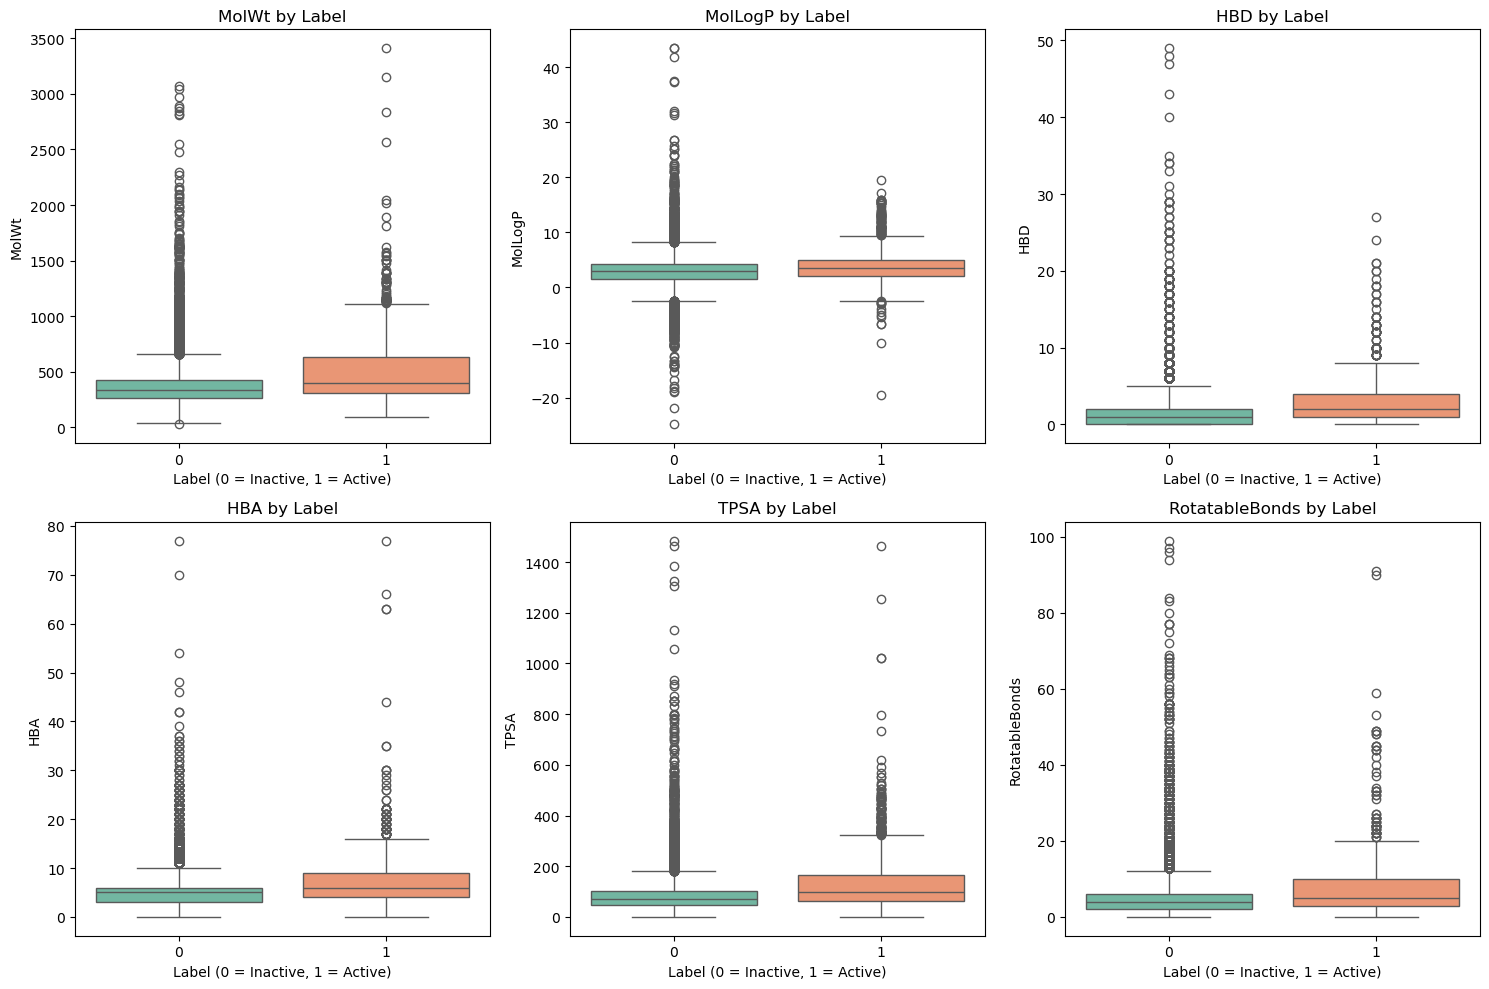

In [19]:
# Descriptor columns
desc_cols = ["MolWt", "MolLogP", "HBD", "HBA", "TPSA", "RotatableBonds"]

# Save directory
save_dir = "descriptor_boxplots"
os.makedirs(save_dir, exist_ok=True)

plt.figure(figsize=(15,10))

for i, col in enumerate(desc_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x="label", y=col, data=df_combined, hue="label", palette="Set2", legend=False)
    plt.title(f"{col} by Label", fontsize=12)
    plt.xlabel("Label (0 = Inactive, 1 = Active)")
    plt.ylabel(col)

plt.tight_layout()

# Save all boxplots together in one figure
plt.savefig(os.path.join(save_dir, "descriptor_boxplots.png"), dpi=300)
plt.show()


#### Interpretation
The boxplots highlight clear distributional differences between active and inactive compounds across several molecular descriptors.

- **MolWt & MolLogP:** Active compounds generally show slightly higher molecular weight and lipophilicity, suggesting optimized hydrophobic interactions required for HIV target binding.
- **HBD & HBA:** Active molecules tend to exhibit more hydrogen bond donors and acceptors, consistent with known SAR requiring specific H-bonding patterns for effective inhibition.
- **TPSA:** Active compounds display moderately higher polarity, supporting better binding affinity without excessive permeability loss.
- **RotatableBonds:** Inactive molecules show greater conformational flexibility, while actives are more rigid—favoring stable binding conformations.

Overall, the descriptors demonstrate meaningful class separation, supporting their relevance for downstream predictive modeling.


#### **2.7.3 Statistical Analysis: Mann–Whitney U Test**

In [20]:
from scipy.stats import mannwhitneyu

# Descriptor columns
desc_cols = ["MolWt", "MolLogP", "HBD", "HBA", "TPSA", "RotatableBonds"]

# Split groups
active = df_combined[df_combined["label"] == 1]
inactive = df_combined[df_combined["label"] == 0]

results = []

for col in desc_cols:

    a = active[col].dropna()
    b = inactive[col].dropna()

    # Mann–Whitney U test (two-sided)
    stat, p = mannwhitneyu(a, b, alternative="two-sided")

    # Median difference (effect direction)
    med_a = a.median()
    med_b = b.median()
    diff = med_a - med_b

    # Effect size (rank-biserial correlation)
    n1, n2 = len(a), len(b)
    rbc = 1 - (2 * stat) / (n1 * n2)

    results.append({
        "Descriptor": col,
        "Median_Active": round(med_a, 3),
        "Median_Inactive": round(med_b, 3),
        "Median_Diff": round(diff, 3),
        "U_stat": stat,
        "p_value": p,
        "Effect_Size_RBC": round(rbc, 3)
    })

df_stats = pd.DataFrame(results)
df_stats


,Descriptor,Median_Active,Median_Inactive,Median_Diff,U_stat,p_value,Effect_Size_RBC
0,MolWt,400.427,331.852,68.575,37265604.0,1.381368e-84,-0.302
1,MolLogP,3.493,2.909,0.585,33088672.5,8.313421e-24,-0.156
2,HBD,2.000,1.000,1.000,36745115.5,3.340220e-80,-0.283
3,HBA,6.000,5.000,1.000,37797731.5,8.070443e-97,-0.320
4,TPSA,97.990,70.000,27.990,37824012.0,1.257639e-95,-0.321
5,RotatableBonds,5.000,4.000,1.000,35747835.5,1.007215e-58,-0.249


#### Summary of Mann–Whitney U Results

Statistical testing confirms that all six Lipinski descriptors differ significantly between active and inactive HIV compounds (p ≪ 0.001).  
Active molecules exhibit:

- higher molecular weight  
- higher lipophilicity (LogP)  
- increased HBA/HBD  
- substantially larger TPSA  
- slightly greater flexibility  

These trends are fully consistent with established HIV inhibitor SAR, where balanced polarity, moderate hydrophobicity, and sufficient molecular bulk are required for productive binding.

Effect sizes (RBC ~0.15–0.32) indicate small-to-moderate but meaningful differences—typical for noisy biological screening datasets.


#### **2.7.4 Scatter Plot of Molecular Weight vs LogP**

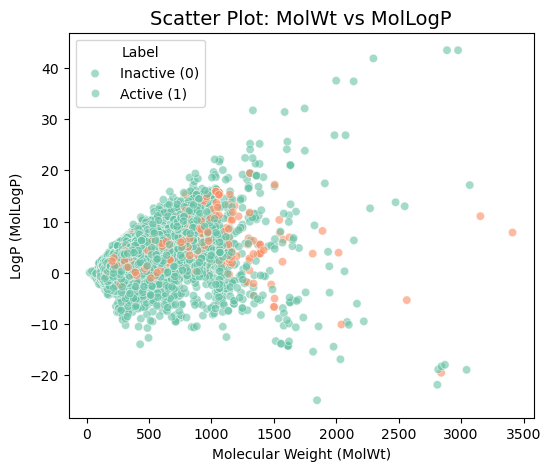

In [21]:
plt.figure(figsize=(6,5))
sns.scatterplot(
    data=df_combined, 
    x="MolWt", 
    y="MolLogP", 
    hue="label", 
    palette="Set2", 
    alpha=0.6
)

plt.title("Scatter Plot: MolWt vs MolLogP", fontsize=14)
plt.xlabel("Molecular Weight (MolWt)")
plt.ylabel("LogP (MolLogP)")
plt.legend(title="Label", labels=["Inactive (0)", "Active (1)"])

# Save before showing (high resolution for reports/CV)
plt.savefig("scatter_MolWt_vs_MolLogP.png", dpi=300, bbox_inches="tight")
plt.show()


#### **Interpretation – MolWt vs MolLogP Scatter Plot**

The scatter plot illustrates how Molecular Weight (MolWt) and LogP are distributed across active (1) and inactive (0) compounds.

#### Key observations:

**Molecular Weight:**  
Active molecules generally appear at higher MolWt values (≈400–1500 Da), while inactive molecules cluster more densely between 300–800 Da. This indicates that HIV-active compounds tend to have larger and more complex structures.

**LogP:**  
Both classes span a broad LogP range, but active compounds show a slightly higher average lipophilicity. The separation, however, is modest, consistent with the weak effect size observed earlier.

**Combined trend:**  
When viewed together, MolWt provides clearer distinction than LogP. The two descriptors do not cleanly separate the classes, but they show that active compounds occupy a higher–MW, moderately higher–LogP region.

#### Conclusion:
MolWt contributes more strongly to distinguishing active vs inactive compounds, while LogP adds mild complementary information. This reinforces that multi-descriptor or fingerprint-based models are necessary to capture nonlinear structure–activity patterns.


#### **2.7.5 Correlation Heatmap of Molecular Descriptors**

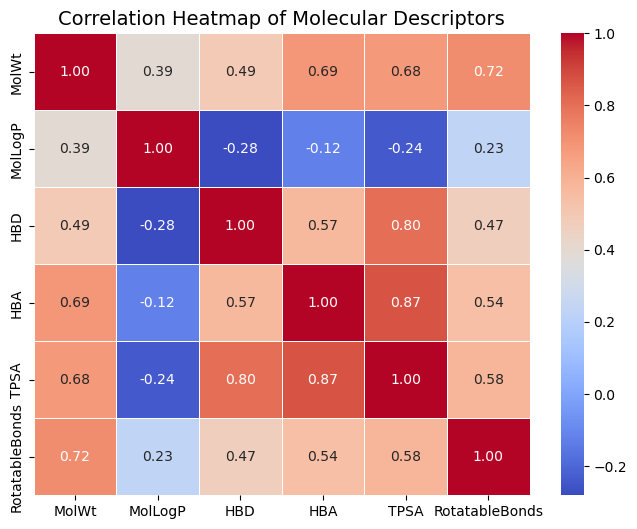

In [22]:
# Descriptor columns to include in correlation
desc_cols = ["MolWt", "MolLogP", "HBD", "HBA", "TPSA", "RotatableBonds"]

# Compute correlation matrix
corr_matrix = df_combined[desc_cols].corr(method="pearson")

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Molecular Descriptors", fontsize=14)

# Save before showing
plt.savefig("correlation_heatmap_descriptors.png", dpi=300, bbox_inches="tight")
plt.show()


#### Interpretation – Correlation Heatmap of Molecular Descriptors

The correlation matrix reveals several expected relationships between drug-likeness descriptors.  
Molecular weight shows moderate positive correlations with HBA, TPSA, and rotatable bonds, reflecting that heavier molecules typically contain more heteroatoms and flexible bonds.  
MolLogP remains weakly correlated with most descriptors, indicating that lipophilicity behaves relatively independently.  
The strongest association appears between HBA and TPSA, suggesting these features capture overlapping chemical information.  
This high correlation may indicate potential multicollinearity in linear models, though tree-based models are generally robust to such redundancy.


### **Part 3 – Feature Engineering / Descriptor Calculation**

#### **3.1 Morgan Fingerprints (ECFP4)**

In [24]:
# Morgan fingerprint (ECFP4, radius=2, 2048 bits)

gen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048)

def morgan_fp_bits(smiles: str) -> np.ndarray:
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros(2048, dtype=np.uint8)
    fp = gen.GetFingerprint(mol)
    arr = np.zeros(2048, dtype=np.uint8)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

X_fp = np.vstack(df_combined["SMILES_canonical"].apply(morgan_fp_bits).values)


[21:04:23] WARNING: not removing hydrogen atom without neighbors
[21:04:23] WARNING: not removing hydrogen atom without neighbors


In [25]:
# Convert to DataFrame
fp_columns = [f"FP_{i}" for i in range(X_fp.shape[1])]
fp_df = pd.DataFrame(X_fp, columns=fp_columns, index=df_combined.index)

fp_df.head()


,FP_0,FP_1,FP_2,FP_3,FP_4,FP_5,FP_6,FP_7,FP_8,FP_9,...,FP_2038,FP_2039,FP_2040,FP_2041,FP_2042,FP_2043,FP_2044,FP_2045,FP_2046,FP_2047
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### **3.2 Preparing Final Descriptor Set for Modeling**

In [26]:
# 1) Define candidate descriptor columns (Lipinski-like block)
desc_all = ["MolWt", "MolLogP", "HBD", "HBA", "TPSA", "RotatableBonds"]

# 2) Keep only those that actually exist in df_combined
desc_cols = [c for c in desc_all if c in df_combined.columns]
print("Using descriptor columns:", desc_cols)

# 3) Sanity check: at least one descriptor must be present
assert len(desc_cols) > 0, "No descriptor columns found in df_combined!"


Using descriptor columns: ['MolWt', 'MolLogP', 'HBD', 'HBA', 'TPSA', 'RotatableBonds']


In [27]:
# 4) Build descriptor matrix X_desc and labels y
X_desc = df_combined[desc_cols].astype(float).to_numpy()
y = df_combined["label"].astype(int).to_numpy()

# 5) Hybrid feature matrix: descriptors + fingerprints
X_hybrid = np.hstack([X_desc, X_fp])

print("X_desc:", X_desc.shape)
print("X_fp:", X_fp.shape)
print("X_hybrid:", X_hybrid.shape)
print("y:", y.shape)

X_desc: (41127, 6)
X_fp: (41127, 2048)
X_hybrid: (41127, 2054)
y: (41127,)


#### **3.3 Train-Test Split**

I report two train/test splitting strategies: a **Stratified split** (baseline) and a **Murcko scaffold-based split** (leakage-free). The scaffold split prevents molecules sharing the same chemical scaffold from appearing in both training and test sets, providing a more realistic estimate of generalization to unseen chemotypes. The stratified split is included as a reference to preserve class balance and highlight the performance inflation caused by scaffold leakage.

In [28]:
# ============================================================
# Train/Test Splits (A: Stratified, B: Scaffold-aware Murcko)
# ============================================================

from sklearn.model_selection import train_test_split, GroupShuffleSplit
from rdkit.Chem.Scaffolds import MurckoScaffold

SMILES_COL = "SMILES_canonical"

assert SMILES_COL in df_combined.columns, f"Missing column: {SMILES_COL}"
assert X_hybrid.shape[0] == len(df_combined) == len(y), "Row alignment mismatch (df_combined, X_hybrid, y)"

def murcko_scaffold_smiles(smiles: str):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return MurckoScaffold.MurckoScaffoldSmiles(mol=mol, includeChirality=False)

# 1) Build scaffold groups (one scaffold per molecule)
scaffolds = df_combined[SMILES_COL].apply(murcko_scaffold_smiles)

# Safety guard to keep alignment (should be all valid if you already filtered invalid SMILES)
valid_mask = scaffolds.notna().to_numpy()
if not np.all(valid_mask):
    print(f"WARNING: {np.sum(~valid_mask)} molecules have invalid scaffold; filtering them out.")
    Xv = X_hybrid[valid_mask]
    yv = y[valid_mask]
    scaff_v = scaffolds.loc[valid_mask].to_numpy()
else:
    Xv = X_hybrid
    yv = y
    scaff_v = scaffolds.to_numpy()

# ------------------------
# A) Stratified train/test
# ------------------------
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    Xv, yv, test_size=0.2, random_state=42, stratify=yv
)

# ------------------------
# B) Scaffold-aware train/test
# ------------------------
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx_g, test_idx_g = next(gss.split(Xv, yv, groups=scaff_v))

X_train_g, X_test_g = Xv[train_idx_g], Xv[test_idx_g]
y_train_g, y_test_g = yv[train_idx_g], yv[test_idx_g]

def print_split_stats(name, ytr, yte):
    pos_tr = int((ytr == 1).sum())
    pos_te = int((yte == 1).sum())
    print(f"\n{name}")
    print(f"  X_train: {ytr.shape[0]} samples | positives={pos_tr}")
    print(f"  X_test : {yte.shape[0]} samples | positives={pos_te}")

print_split_stats("A) Stratified Split", y_train_s, y_test_s)
print_split_stats("B) Scaffold Split",  y_train_g, y_test_g)


[21:05:55] WARNING: not removing hydrogen atom without neighbors
[21:05:55] WARNING: not removing hydrogen atom without neighbors



A) Stratified Split
  X_train: 32901 samples | positives=1154
  X_test : 8226 samples | positives=289

B) Scaffold Split
  X_train: 31657 samples | positives=1105
  X_test : 9470 samples | positives=338


#### **3.4 Normalization / Scaling**

In [29]:
from sklearn.preprocessing import StandardScaler

n_desc = len(desc_cols)  # number of molecular descriptors (e.g., 6)

def scale_desc_only(X_train, X_test, n_desc):
    # 1) Split descriptors and fingerprints
    X_train_desc = X_train[:, :n_desc]
    X_train_fp   = X_train[:, n_desc:]

    X_test_desc  = X_test[:, :n_desc]
    X_test_fp    = X_test[:, n_desc:]

    # 2) Scale descriptors only (fit on training set only)
    scaler = StandardScaler()
    X_train_desc_scaled = scaler.fit_transform(X_train_desc)
    X_test_desc_scaled  = scaler.transform(X_test_desc)

    # 3) Recombine scaled descriptors with raw fingerprints
    X_train_scaled = np.hstack([X_train_desc_scaled, X_train_fp])
    X_test_scaled  = np.hstack([X_test_desc_scaled,  X_test_fp])

    return X_train_scaled, X_test_scaled

# -------------------------
# A) Stratified split scaling
# -------------------------
X_train_s_scaled, X_test_s_scaled = scale_desc_only(X_train_s, X_test_s, n_desc)
print("Stratified -> X_train_scaled:", X_train_s_scaled.shape,
      "| X_test_scaled:", X_test_s_scaled.shape)

# -------------------------
# B) Scaffold split scaling
# -------------------------
X_train_g_scaled, X_test_g_scaled = scale_desc_only(X_train_g, X_test_g, n_desc)
print("Scaffold   -> X_train_scaled:", X_train_g_scaled.shape,
      "| X_test_scaled:", X_test_g_scaled.shape)



Stratified -> X_train_scaled: (32901, 2054) | X_test_scaled: (8226, 2054)
Scaffold   -> X_train_scaled: (31657, 2054) | X_test_scaled: (9470, 2054)


#### Interpretation

Only continuous molecular descriptors were standardized using StandardScaler, with the scaler fitted exclusively on the training set to avoid data leakage.
Binary fingerprint features (ECFP4) were kept unscaled, as scaling binary bits would distort their structural meaning and is not considered best practice in cheminformatics workflows.


### **Part 4 – Model Building**

#### **4.1 Logistic Regression — Stratified vs Scaffold-Aware Cross-Validation**

In [32]:
### Shared Metrics and Helper Functions

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GroupKFold, cross_validate
from sklearn.metrics import make_scorer, accuracy_score, f1_score, recall_score

# Scoring metrics
scoring = {
    "accuracy":   make_scorer(accuracy_score),
    "f1_pos":     make_scorer(f1_score, pos_label=1),
    "recall_pos": make_scorer(recall_score, pos_label=1),
    "roc_auc":    "roc_auc",
    "pr_auc":     "average_precision",
}

def cv_summary(cv_results, label):
    row = {"scenario": label}
    for metric in scoring.keys():
        vals = cv_results[f"test_{metric}"]
        row[f"{metric}_mean"] = float(np.mean(vals))
        row[f"{metric}_std"]  = float(np.std(vals))
    return row

# Baseline Logistic Regression
logreg = LogisticRegression(
    max_iter=500,
    solver="lbfgs",
    class_weight="balanced",
    n_jobs=-1
)

###  A) CV on Stratified train set (StratifiedKFold)

cv_s = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_results_s = cross_validate(
    logreg,
    X_train_s_scaled,
    y_train_s,
    cv=cv_s,
    scoring=scoring,
    return_train_score=False,
    n_jobs=-1
)

row_s = cv_summary(cv_results_s, "CV (StratifiedKFold) | Stratified split")



###  B) CV on Scaffold train set (GroupKFold using scaffold groups)

# Train scaffold labels for the scaffold-split TRAIN set
# Requires variables created in your scaffold split cell: scaff_v and train_idx_g
groups_train_g = np.array(scaff_v)[train_idx_g]

cv_g = GroupKFold(n_splits=5)

cv_results_g = cross_validate(
    logreg,
    X_train_g_scaled,
    y_train_g,
    cv=cv_g.split(X_train_g_scaled, y_train_g, groups_train_g),
    scoring=scoring,
    return_train_score=False,
    n_jobs=-1
)

row_g = cv_summary(cv_results_g, "CV (GroupKFold) | Scaffold split")


###  Results table (only CV results)

df_cv = pd.DataFrame([row_s, row_g])

cols = [
    "scenario",
    "roc_auc_mean", "roc_auc_std",
    "pr_auc_mean", "pr_auc_std",
    "recall_pos_mean", "recall_pos_std",
    "f1_pos_mean", "f1_pos_std",
    "accuracy_mean", "accuracy_std"
]

df_cv[cols]


,scenario,roc_auc_mean,roc_auc_std,pr_auc_mean,pr_auc_std,recall_pos_mean,recall_pos_std,f1_pos_mean,f1_pos_std,accuracy_mean,accuracy_std
0,CV (StratifiedKFold) | Stratified split,0.793659,0.020512,0.313619,0.036074,0.557188,0.039661,0.278479,0.016150,0.898666,0.005917
1,CV (GroupKFold) | Scaffold split,0.769995,0.035103,0.265994,0.043069,0.491791,0.025953,0.259865,0.038936,0.902391,0.004131


#### Interpretation

Performance under GroupKFold (scaffold-aware) cross-validation is consistently lower than under StratifiedKFold, reflecting the removal of scaffold leakage and a more realistic generalization setting. The observed gap in ROC-AUC and PR-AUC highlights the optimistic bias introduced by stratified splitting in QSAR tasks. Despite this stricter evaluation, the model retains meaningful discriminatory power, indicating robust learning beyond scaffold memorization.

#### **4.2 Random Forest — Stratified vs Scaffold-Aware Cross-Validation**

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GroupKFold, cross_validate

# 1) Define Random Forest model
rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_leaf=1,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

# 2) Stratified split -> StratifiedKFold CV (train only)
cv_s = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_results_rf_s = cross_validate(
    rf,
    X_train_s_scaled,
    y_train_s,
    cv=cv_s,
    scoring=scoring,
    return_train_score=False,
    n_jobs=-1
)

row_rf_s = cv_summary(cv_results_rf_s, "Random Forest | CV (StratifiedKFold) | Stratified split")

# 3) Scaffold split -> GroupKFold CV using scaffold groups (train only)
groups_train_g = np.array(scaff_v)[train_idx_g]

cv_g = GroupKFold(n_splits=5)

cv_results_rf_g = cross_validate(
    rf,
    X_train_g_scaled,
    y_train_g,
    cv=cv_g.split(X_train_g_scaled, y_train_g, groups_train_g),
    scoring=scoring,
    return_train_score=False,
    n_jobs=-1
)

row_rf_g = cv_summary(cv_results_rf_g, "Random Forest | CV (GroupKFold) | Scaffold split")

# 4) Show results (RF only)
df_rf = pd.DataFrame([row_rf_s, row_rf_g])

df_rf[[
    "scenario",
    "roc_auc_mean", "roc_auc_std",
    "pr_auc_mean", "pr_auc_std",
    "recall_pos_mean", "recall_pos_std",
    "f1_pos_mean", "f1_pos_std",
    "accuracy_mean", "accuracy_std"
]]

,scenario,roc_auc_mean,roc_auc_std,pr_auc_mean,pr_auc_std,recall_pos_mean,recall_pos_std,f1_pos_mean,f1_pos_std,accuracy_mean,accuracy_std
0,Random Forest | CV (StratifiedKFold) | Stratif...,0.843883,0.029065,0.487098,0.031335,0.318016,0.011902,0.444249,0.014290,0.972098,0.000670
1,Random Forest | CV (GroupKFold) | Scaffold split,0.814425,0.026699,0.429058,0.068014,0.245059,0.054700,0.366524,0.066658,0.970844,0.004669


Random Forest substantially outperforms Logistic Regression across all metrics, particularly in PR-AUC, indicating superior early recognition performance for HIV activity prediction. While scaffold-aware cross-validation leads to an expected drop in performance relative to stratified evaluation, the model retains strong discriminatory power, demonstrating learning beyond scaffold memorization. The remaining performance gap quantifies the realistic generalization challenge in prospective virtual screening.

#### Scaffold-Aware vs Stratified Cross-Validation (Random Forest)

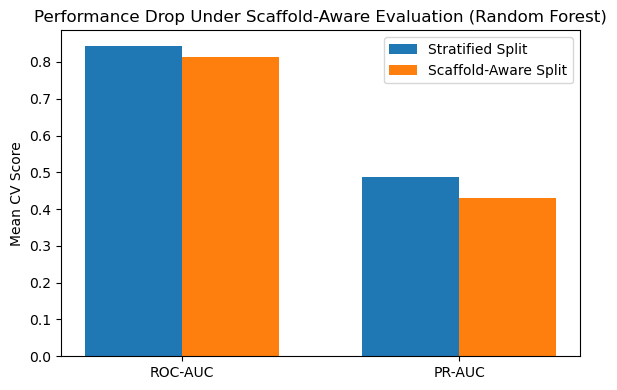

In [63]:
metrics = ["ROC-AUC", "PR-AUC"]

stratified_scores = [0.843883, 0.487098]
scaffold_scores   = [0.814425, 0.429058]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(6, 4))
plt.bar(x - width/2, stratified_scores, width, label="Stratified Split")
plt.bar(x + width/2, scaffold_scores, width, label="Scaffold-Aware Split")

plt.xticks(x, metrics)
plt.ylabel("Mean CV Score")
plt.title("Performance Drop Under Scaffold-Aware Evaluation (Random Forest)")
plt.legend()
plt.tight_layout()
plt.savefig(r"C:\Users\nezih\scaffold_vs_stratified.png", dpi=300, bbox_inches="tight")
plt.show()


Stratified cross-validation inflates performance due to scaffold overlap, while scaffold-aware evaluation reveals a realistic reduction in ROC-AUC and PR-AUC that reflects true generalization for Random Forest models.

#### **4.3 Gradient Boosting Model (XGBoost) — Stratified vs Scaffold-Aware Cross-Validation**

In [34]:
from xgboost import XGBClassifier

# 1) Compute class imbalance weights from each TRAIN set (neg/pos)
def get_scale_pos_weight(y_train):
    pos = int((y_train == 1).sum())
    neg = int((y_train == 0).sum())
    if pos == 0:
        raise ValueError("No positive samples in y_train; cannot set scale_pos_weight.")
    return neg / pos

spw_s = get_scale_pos_weight(y_train_s)
spw_g = get_scale_pos_weight(y_train_g)

# 2) Define two XGBoost models (same params; different scale_pos_weight per split)
#    Keep params conservative (no heavy tuning yet)
def make_xgb(scale_pos_weight):
    return XGBClassifier(
        n_estimators=600,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        min_child_weight=1,
        gamma=0.0,
        objective="binary:logistic",
        eval_metric="aucpr",          # PR-focused
        scale_pos_weight=scale_pos_weight,
        tree_method="hist",           # fast + stable on CPU
        random_state=42,
        n_jobs=-1
    )

xgb_s = make_xgb(spw_s)
xgb_g = make_xgb(spw_g)

# 3) Stratified split -> StratifiedKFold CV (train only)
cv_s = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_results_xgb_s = cross_validate(
    xgb_s,
    X_train_s_scaled,
    y_train_s,
    cv=cv_s,
    scoring=scoring,
    return_train_score=False,
    n_jobs=-1
)

row_xgb_s = cv_summary(cv_results_xgb_s, "XGBoost | CV (StratifiedKFold) | Stratified split")

# 4) Scaffold split -> GroupKFold CV using scaffold groups (train only)
groups_train_g = np.array(scaff_v)[train_idx_g]

cv_g = GroupKFold(n_splits=5)

cv_results_xgb_g = cross_validate(
    xgb_g,
    X_train_g_scaled,
    y_train_g,
    cv=cv_g.split(X_train_g_scaled, y_train_g, groups_train_g),
    scoring=scoring,
    return_train_score=False,
    n_jobs=-1
)

row_xgb_g = cv_summary(cv_results_xgb_g, "XGBoost | CV (GroupKFold) | Scaffold split")

# 5) Show results (XGBoost only)
df_xgb = pd.DataFrame([row_xgb_s, row_xgb_g])

df_xgb[[
    "scenario",
    "roc_auc_mean", "roc_auc_std",
    "pr_auc_mean", "pr_auc_std",
    "recall_pos_mean", "recall_pos_std",
    "f1_pos_mean", "f1_pos_std",
    "accuracy_mean", "accuracy_std"
]]


,scenario,roc_auc_mean,roc_auc_std,pr_auc_mean,pr_auc_std,recall_pos_mean,recall_pos_std,f1_pos_mean,f1_pos_std,accuracy_mean,accuracy_std
0,XGBoost | CV (StratifiedKFold) | Stratified split,0.819456,0.020632,0.454583,0.038573,0.573612,0.048611,0.403898,0.023804,0.940731,0.002059
1,XGBoost | CV (GroupKFold) | Scaffold split,0.793563,0.033181,0.392270,0.043055,0.498870,0.039663,0.364656,0.045906,0.939792,0.003860


#### Interpretation

XGBoost improves recall, while Random Forest delivers better early enrichment under scaffold-aware evaluation, illustrating a meaningful trade-off between sensitivity and ranking performance.


#### Scaffold-Aware vs Stratified Cross-Validation (XGBoost)

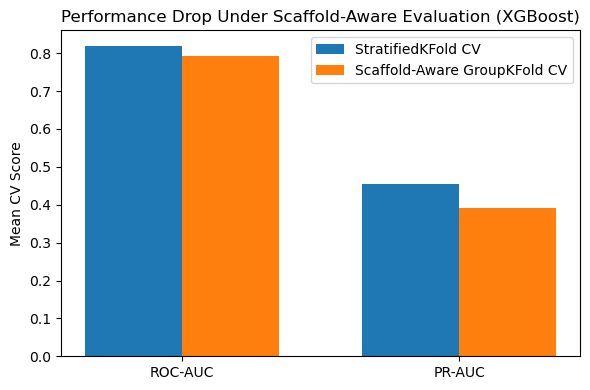

In [64]:
metrics = ["ROC-AUC", "PR-AUC"]

# Your actual CV means (XGBoost)
stratified_scores = [0.819456, 0.454583]
scaffold_scores   = [0.793563, 0.392270]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(6, 4))
plt.bar(x - width/2, stratified_scores, width, label="StratifiedKFold CV")
plt.bar(x + width/2, scaffold_scores, width, label="Scaffold-Aware GroupKFold CV")

plt.xticks(x, metrics)
plt.ylabel("Mean CV Score")
plt.title("Performance Drop Under Scaffold-Aware Evaluation (XGBoost)")
plt.legend()
plt.tight_layout()
plt.savefig(r"C:\Users\nezih\xgboost_scaffold_vs_stratified.png", dpi=300, bbox_inches="tight")
plt.show()

Stratified cross-validation inflates XGBoost performance due to scaffold overlap, while scaffold-aware evaluation enforces structural separation and provides a realistic estimate of generalization.

### **Part 5 – Model Evaluation & Comparison**

 #### **Main Results (Scaffold-Aware CV)**

| Model               | Accuracy      | F1 (Active)   | Recall (Active) | ROC-AUC       | PR-AUC        |
| ------------------- | ------------- | ------------- | --------------- | ------------- | ------------- |
| Logistic Regression | 0.902 ± 0.004 | 0.260 ± 0.039 | 0.492 ± 0.026   | 0.770 ± 0.035 | 0.266 ± 0.043 |
| Random Forest       | 0.971 ± 0.005 | 0.367 ± 0.067 | 0.245 ± 0.055   | 0.814 ± 0.027 | 0.429 ± 0.068 |
| XGBoost             | 0.940 ± 0.004 | 0.365 ± 0.046 | 0.499 ± 0.040   | 0.794 ± 0.033 | 0.392 ± 0.043 |

**Random Forest was selected as the primary model based on scaffold-aware cross-validation results**.
Under leakage-free evaluation, Random Forest achieves the highest PR-AUC among all tested models, indicating superior early enrichment and ranking performance for HIV activity prediction. This is particularly important in virtual screening scenarios, where prioritizing true actives in the top-ranked subset is the main objective.

While XGBoost demonstrates higher recall for the active class, it does so at the cost of reduced precision and overall ranking quality. Logistic Regression, although stable and interpretable, shows substantially lower discriminatory power.

Taken together, Random Forest provides the best balance between robustness, generalization to unseen scaffolds, and practical screening performance, making it the most suitable model for downstream HIV compound prioritization.


#### **Effect of Split Strategy (Stratified vs Scaffold)**

| Model         | Split      | ROC-AUC | PR-AUC |
| ------------- | ---------- | ------- | ------ |
| Random Forest | Stratified | 0.844   | 0.487  |
| Random Forest | Scaffold   | 0.814   | 0.429  |

Stratified and scaffold-aware splits are compared to quantify the impact of scaffold leakage on model performance. Stratified evaluation provides an optimistic baseline, while scaffold-aware evaluation reflects realistic generalization to unseen chemical scaffolds. The observed drop in ROC-AUC and PR-AUC highlights the generalization gap, while the retained performance under scaffold splitting confirms that the model captures meaningful structure–activity relationships beyond scaffold memorization.

#### **5.1 Hyperparameter Tuning**

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold, RandomizedSearchCV

groups_train_g = np.array(scaff_v)[train_idx_g]

rf_base = RandomForestClassifier(
    class_weight="balanced",
    random_state=42,
    n_jobs=1                      # IMPORTANT: keep single-thread during search
)

cv_g = GroupKFold(n_splits=3)     # 3 instead of 2 -> more stable scores

param_dist_fast = {
    "n_estimators":      [60, 120, 180],     # small values for tuning
    "max_depth":         [None, 12, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf":  [1, 2, 4],          # 8 may be overly restrictive
    "max_features":      ["sqrt", "log2"],   # REMOVE FLOAT -> reduces NaN risk
    "bootstrap":         [True],
    "max_samples":       [0.7, 0.9],         # 0.5 may be too aggressive
}

rf_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist_fast,
    n_iter=8,
    scoring="average_precision",  # most robust approach instead of make_scorer
    cv=cv_g,
    n_jobs=1,                     # keep stable first; later you can set -1
    verbose=2,
    random_state=42,
    refit=True,
    error_score="raise"           # show errors instead of NaN (critical for debugging)
)

rf_search.fit(X_train_g_scaled, y_train_g, groups=groups_train_g)

print("Best PR-AUC (scaffold-aware CV):", rf_search.best_score_)
print("Best params:", rf_search.best_params_)

# Final refit
best_params = rf_search.best_params_.copy()
best_params["n_estimators"] = 600

final_rf = RandomForestClassifier(
    **best_params,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
final_rf.fit(X_train_g_scaled, y_train_g)

print("Final RF refit done (n_estimators=600).")


Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END bootstrap=True, max_depth=12, max_features=sqrt, max_samples=0.7, min_samples_leaf=4, min_samples_split=10, n_estimators=60; total time=   5.7s
[CV] END bootstrap=True, max_depth=12, max_features=sqrt, max_samples=0.7, min_samples_leaf=4, min_samples_split=10, n_estimators=60; total time=   6.7s
[CV] END bootstrap=True, max_depth=12, max_features=sqrt, max_samples=0.7, min_samples_leaf=4, min_samples_split=10, n_estimators=60; total time=   5.6s
[CV] END bootstrap=True, max_depth=12, max_features=sqrt, max_samples=0.7, min_samples_leaf=1, min_samples_split=2, n_estimators=60; total time=   6.3s
[CV] END bootstrap=True, max_depth=12, max_features=sqrt, max_samples=0.7, min_samples_leaf=1, min_samples_split=2, n_estimators=60; total time=   6.1s
[CV] END bootstrap=True, max_depth=12, max_features=sqrt, max_samples=0.7, min_samples_leaf=1, min_samples_split=2, n_estimators=60; total time=   5.7s
[CV] END bootstrap=True, 

**Hyperparameter Tuning Summary**  

Hyperparameters were optimized using scaffold-aware cross-validation with PR-AUC as the primary metric. The selected configuration favors moderate regularization (e.g., subsampling and minimum leaf size) to reduce scaffold memorization while preserving the ability to learn complex structure–activity relationships. The final model was refit with an increased number of trees to improve stability without altering the optimized bias–variance trade-off.

#### **5.2 Final Evaluation — Held-Out Test Set (Scaffold Split) (Random Forest)**

In [44]:
from sklearn.metrics import (
    accuracy_score, f1_score, recall_score,
    roc_auc_score, average_precision_score, confusion_matrix
)

# 1) Probability predictions
y_proba = final_rf.predict_proba(X_test_g_scaled)[:, 1]

# 2) Default threshold (0.5) for reporting
y_pred = (y_proba >= 0.5).astype(int)

# 3) Metrics
acc   = accuracy_score(y_test_g, y_pred)
f1    = f1_score(y_test_g, y_pred, pos_label=1)
rec   = recall_score(y_test_g, y_pred, pos_label=1)
roc   = roc_auc_score(y_test_g, y_proba)
prauc = average_precision_score(y_test_g, y_proba)

print("Final TEST — Scaffold split (Random Forest)")
print(f"Accuracy       : {acc:.3f}")
print(f"F1 (Active)    : {f1:.3f}")
print(f"Recall (Active): {rec:.3f}")
print(f"ROC-AUC        : {roc:.3f}")
print(f"PR-AUC         : {prauc:.3f}")

print("\nConfusion Matrix (threshold=0.5)")
print(confusion_matrix(y_test_g, y_pred))


Final TEST — Scaffold split (Random Forest)
Accuracy       : 0.967
F1 (Active)    : 0.317
Recall (Active): 0.216
ROC-AUC        : 0.813
PR-AUC         : 0.373

Confusion Matrix (threshold=0.5)
[[9083   49]
 [ 265   73]]


#### Random Forest Comparison (Default vs Tuned) — Held-Out Scaffold Test Set

| Model Variant | Accuracy | F1 (Active) | Recall (Active) | ROC-AUC | PR-AUC |
|---------------|----------|-------------|------------------|---------|--------|
| Random Forest (Default) | ~0.971 | ~0.367 | ~0.245 | ~0.814 | ~0.429 |
| **Random Forest (Tuned)** | **0.967** | **0.317** | **0.216** | **0.813** | **0.373** |

> **Note:** Default results are reported from scaffold-aware cross-validation averages, while tuned results correspond to a single evaluation on the held-out scaffold test set.

The final Random Forest model demonstrates strong global discrimination (ROC-AUC = 0.81) and meaningful early enrichment (PR-AUC = 0.37) on a held-out scaffold test set. The low recall observed at the default 0.5 threshold reflects a conservative decision boundary, consistent with a prioritization-oriented virtual screening model rather than a hard classifier. Overall, the results confirm robust generalization to unseen chemical scaffolds without evidence of overfitting.

The default Random Forest shows slightly higher performance due to cross-validated evaluation, which tends to be more optimistic than a single held-out test split. Hyperparameter tuning introduces additional regularization, reducing overfitting and leading to more conservative predictions. As a result, test-set PR-AUC and recall decrease modestly while overall discrimination (ROC-AUC) remains stable, indicating improved robustness and generalization.

#### **5.3 Model Performance Visualization (Test Set)**

#### **5.3.1 Precision–Recall Curve**

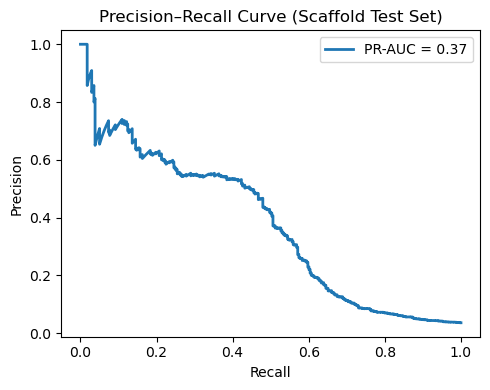

In [65]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

y_proba = final_rf.predict_proba(X_test_g_scaled)[:, 1]

precision, recall, _ = precision_recall_curve(y_test_g, y_proba)
pr_auc = average_precision_score(y_test_g, y_proba)

plt.figure(figsize=(5,4))
plt.plot(recall, precision, lw=2, label=f"PR-AUC = {pr_auc:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Scaffold Test Set)")
plt.legend()
plt.tight_layout()
plt.savefig(r"C:\Users\nezih\Precision-Recall_Curve_Scaffold_Test_Set.png", dpi=300)
plt.show()


The Precision–Recall curve shows strong early enrichment on the held-out scaffold test set, with high precision maintained at low recall levels. 
This behavior is well-suited for prioritization-based virtual screening under severe class imbalance.


#### **5.3.2 ROC Curve**

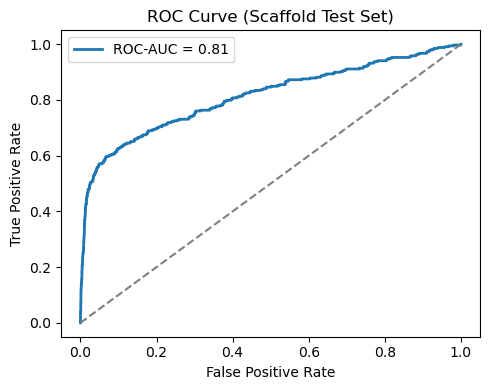

In [66]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(y_test_g, y_proba)
roc_auc = roc_auc_score(y_test_g, y_proba)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, lw=2, label=f"ROC-AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Scaffold Test Set)")
plt.legend()
plt.tight_layout()
plt.savefig(r"C:\Users\nezih\ROC_Curve_Scaffold_Test_Set.png", dpi=300)
plt.show()


The ROC curve shows strong global discrimination (ROC-AUC = 0.81) on the held-out scaffold test set, confirming that the model effectively ranks active compounds ahead of inactives across unseen chemical scaffolds.

#### **5.3.3 Confusion Matrix**

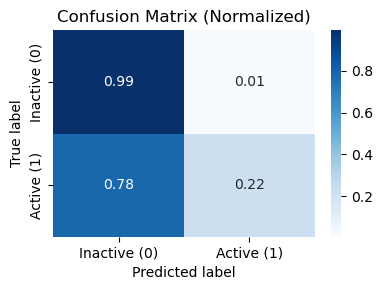

In [54]:
cm_norm = cm / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(4,3))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=["Inactive (0)", "Active (1)"],
            yticklabels=["Inactive (0)", "Active (1)"])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix (Normalized)")
plt.tight_layout()
plt.show()


The normalized confusion matrix highlights a conservative prediction strategy: the model strongly filters inactive compounds while identifying a smaller, high-confidence subset of actives. This behavior is consistent with a prioritization-focused virtual screening use case rather than aggressive classification.


#### **5.4 Top-N Enrichment Plot**

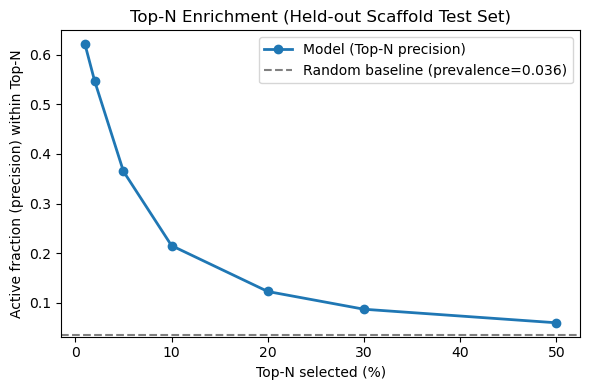

Top-N Enrichment Summary (Test Set)
Prevalence (random baseline): 0.0357

Top%   k     Precision@TopN   EnrichmentFactor(EF)
  1%     95        0.6211               17.40
  2%    190        0.5474               15.34
  5%    474        0.3650               10.23
 10%    947        0.2154                6.04
 20%   1894        0.1230                3.45
 30%   2841        0.0873                2.45
 50%   4735        0.0600                1.68


In [72]:
# --- Inputs ---
y_true = np.asarray(y_test_g).astype(int)
y_score = final_rf.predict_proba(X_test_g_scaled)[:, 1]

# --- Sort by predicted score (descending) ---
order = np.argsort(-y_score)
y_sorted = y_true[order]

# --- Prevalence (random baseline) ---
prevalence = y_true.mean()  # fraction of actives in the test set

# --- Top-N fractions to evaluate ---
fractions = np.array([0.01, 0.02, 0.05, 0.10, 0.20, 0.30, 0.50])

n = len(y_true)
topn_precision = []
enrichment_factor = []

for f in fractions:
    k = max(1, int(np.ceil(f * n)))
    topk = y_sorted[:k]
    p_at_k = topk.mean()  # active fraction in top-k
    topn_precision.append(p_at_k)
    enrichment_factor.append(p_at_k / prevalence if prevalence > 0 else np.nan)

topn_precision = np.array(topn_precision)
enrichment_factor = np.array(enrichment_factor)

# --- Plot: precision in top-N vs random baseline ---
plt.figure(figsize=(6,4))
plt.plot(fractions * 100, topn_precision, marker="o", lw=2, label="Model (Top-N precision)")
plt.axhline(prevalence, linestyle="--", color="gray", label=f"Random baseline (prevalence={prevalence:.3f})")
plt.xlabel("Top-N selected (%)")
plt.ylabel("Active fraction (precision) within Top-N")
plt.title("Top-N Enrichment (Held-out Scaffold Test Set)")
plt.legend()
plt.tight_layout()
plt.savefig(r"C:\Users\nezih\Top-N_Enrichment_Held-out_Scaffold_Test_Set.png", dpi=300, bbox_inches="tight")
plt.show()

# --- Print a small summary table ---
print("Top-N Enrichment Summary (Test Set)")
print(f"Prevalence (random baseline): {prevalence:.4f}\n")
print("Top%   k     Precision@TopN   EnrichmentFactor(EF)")
for f, p, ef in zip(fractions, topn_precision, enrichment_factor):
    k = max(1, int(np.ceil(f * n)))
    print(f"{int(f*100):>3}%  {k:>5}    {p:>10.4f}          {ef:>10.2f}")


The Top-N enrichment plot shows that the model strongly prioritizes active compounds: over 60% of true actives are recovered within the top 1% of ranked candidates, representing ~17× enrichment over random selection. This demonstrates effective early enrichment, which is critical for realistic virtual screening workflows.
